In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym
import re
from gymnasium.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
import pygame
import matplotlib.pyplot as plt
import mdp_alvaro as mdp
from hiive.mdptoolbox import example as ex

In [2]:
# Important Links
# https://github.com/hiive/hiivemdptoolbox
# https://github.com/openai/gym
# https://gymnasium.farama.org/environments/toy_text/frozen_lake/

In [3]:
np.random.seed(19839526)
frozen_lake = generate_random_map(20)
env = FrozenLakeEnv(desc=frozen_lake, is_slippery=True,render_mode="ansi")
env = env.unwrapped
desc = env.unwrapped.desc

In [4]:
env.action_space

Discrete(4)

In [5]:
env.observation_space

Discrete(400)

In [6]:
# Got most of the code for this cell and the next from https://github.com/hiive/hiivemdptoolbox/blob/master/hiive/mdptoolbox/openai.py
transitions = env.P
actions = int(re.findall(r'\d+', str(env.action_space))[0])
states = int(re.findall(r'\d+', str(env.observation_space))[0])
P = np.zeros((actions, states, states))
R = np.zeros((states, actions))
#print(P)

In [7]:
for state in range(states):
    for action in range(actions):
         for i in range(len(transitions[state][action])):
             tran_prob = transitions[state][action][i][0]
             state_ = transitions[state][action][i][1]
             R[state][action] += tran_prob*transitions[state][action][i][2]
             P[action, state, state_] += tran_prob

In [8]:
frozen_lake

['SFFHFFHFFFFFFFFFFFFF',
 'FHFFFFFFFFHFFHHFFFFF',
 'FFFFFHHFFHFFHHFFFHFH',
 'FFHFFFHFFFFFFFHHFFFF',
 'FFHFFFFFFFFFFFFHFFFF',
 'HFFHFFHFFFFFHFFFHFFF',
 'FHFFFFHHFFFHFHFFFFFF',
 'FFFFFFHFFFFFFFFFFHFH',
 'FFFFFFHHHHFFFHHHFFFF',
 'HHFFFFFFFFFFFFFFFFFF',
 'FFHHFFFFHHFFFFFFFFFF',
 'FFHFFFFFFFFFFFFFHFFF',
 'FHFFHFFFFFHFFFFFFFFF',
 'HFFFFFFFFFFFHFFFFFFF',
 'FFFHHHFFFFFFHHFFHFHF',
 'FFFFFFFHFFFFFFHFFFFF',
 'FFHHFHFFFFFFFFFFHHFF',
 'HFFHFFHFFFFHFFHFFFHF',
 'FFFFFFFHFFHFFFFFFFFF',
 'FFFFFFFFFFFFFFFFFFFG']

In [9]:
def colors():
    return {
        b'S': 'green',
        b'F': 'skyblue',
        b'H': 'darkblue',
        b'G': 'gold',
    }

def directions():
    return {
        3: '⬆',
        2: '➡',
        1: '⬇',
        0: '⬅'
    }
def show_map(title,  map_desc, color_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, xlim=(0, map_desc.shape[1]), ylim=(0, map_desc.shape[0]))
    font_size = 'x-large'
    if map_desc.shape[1] > 16:
        font_size = 'small'
    plt.title(title)
    for i in range(map_desc.shape[0]):
        for j in range(map_desc.shape[1]):
            y = map_desc.shape[0] - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1)
            p.set_facecolor(color_map[map_desc[i,j]])   
            plt.axis('off')
            ax.add_patch(p)
    plt.xlim((0, map_desc.shape[1]))
    plt.ylim((0, map_desc.shape[0]))
    plt.tight_layout()
    plt.show()

    return (plt)

def show_policy_map(title, policy, map_desc, color_map, direction_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, xlim=(0, policy.shape[1]), ylim=(0, policy.shape[0]))
    font_size = 'x-large'
    if policy.shape[1] > 16:
        font_size = 'small'
    plt.title(title)
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            y = policy.shape[0] - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1)
            p.set_facecolor(color_map[map_desc[i,j]])
            ax.add_patch(p)

            text = ax.text(x+0.5, y+0.5, direction_map[policy[i, j]], weight='bold', size=font_size,
                           horizontalalignment='center', verticalalignment='center', color='w')
            

    plt.axis('off')
    plt.xlim((0, policy.shape[1]))
    plt.ylim((0, policy.shape[0]))
    plt.tight_layout()
    plt.show()
    #plt.savefig(title+str('.png'))
    #plt.close()

    return (plt)

In [10]:
desc[1,1]

b'H'

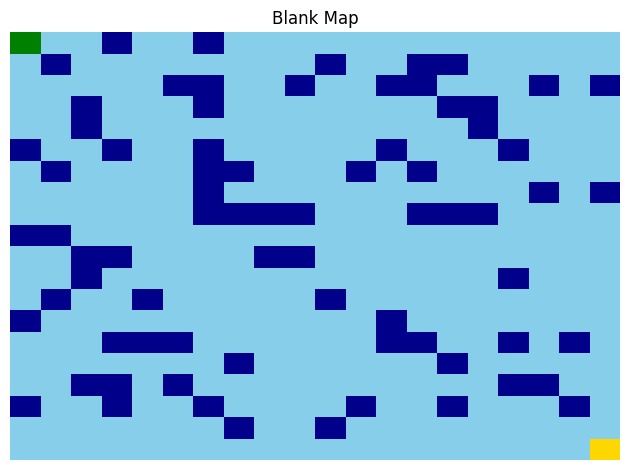

1.0


In [11]:
show_map("Blank Map",  desc, colors())
print(P[3,3,3])

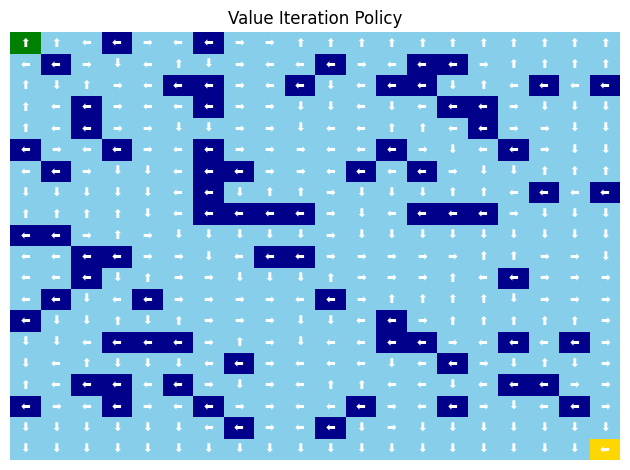

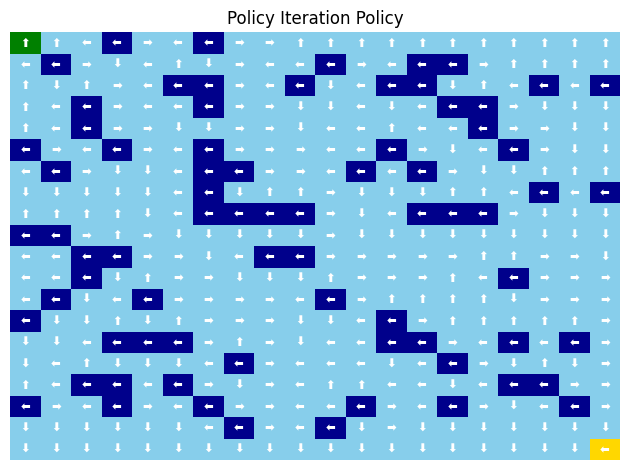

15.907044887542725
4711
65.64115619659424
26
1


In [12]:
vi = mdp.ValueIteration(P, R, gamma=0.999999,epsilon=0.00000001, max_iter=R.shape[0]**R.shape[1])
vi.run()
pi = mdp.PolicyIteration(P, R, gamma=0.999999, policy0=None,eval_type=1, max_iter=R.shape[0]**R.shape[1])
pi.run()
#pi2 = mdp.PolicyIteration(P, R, gamma=0.999999, policy0=None,eval_type=0, max_iter=R.shape[0]**R.shape[1])
#pi2.run()
show_policy_map("Value Iteration Policy", np.asarray(vi.policy).reshape(desc.shape[0],desc.shape[1]), desc, colors(),directions())
show_policy_map("Policy Iteration Policy", np.asarray(pi.policy).reshape(desc.shape[0],desc.shape[1]), desc, colors(),directions())
solutionPi = pi.policy
solutionVi = vi.policy
print(vi.time)
print(vi.iter)
print(pi.time)
print(pi.iter)
print((np.array(vi.policy) != np.array(pi.policy)).sum())
#print((np.array(pi2.policy) != np.array(pi.policy)).sum())
solution = pi.policy

In [13]:
data = [(0,0,0,0)]

for g in range(999):
    vi = mdp.ValueIteration(P, R, gamma=0.99999-g/1000,epsilon=0.0001, max_iter=R.shape[0]**R.shape[1])
    vi.run()
    data.append((0.999-g/1000,(np.array(vi.policy) != np.array(solution)).sum(), vi.time,vi.iter))  
viAnalisys = pd.DataFrame(data, columns=['Gamma','Error', 'Time', 'Iterations'])
viAnalisys = viAnalisys.iloc[1: , :]
print(viAnalisys )
viAnalisys.to_csv("FrozenLake_viAnalisys.csv")

     Gamma  Error      Time  Iterations
1    0.999      6  3.993995         933
2    0.998     15  1.873375         761
3    0.997     19  2.938248         627
4    0.996     26  2.638533         477
5    0.995     29  1.153106         406
..     ...    ...       ...         ...
995  0.005    253  0.000000           1
996  0.004    253  0.000000           1
997  0.003    253  0.015621           1
998  0.002    253  0.000000           1
999  0.001    253  0.046861           1

[999 rows x 4 columns]


In [ ]:
data = [(0,0,0,0)]
for g in range(999):
    pi = mdp.PolicyIteration(P, R, gamma=0.99999-g/1000, policy0=None,eval_type=1, max_iter=R.shape[0]**R.shape[1])
    pi.run()
    data.append((0.999-g/1000,(np.array(pi.policy) != np.array(solution)).sum(), pi.time,pi.iter))  
piAnalisys = pd.DataFrame(data, columns=['Gamma','Error', 'Time', 'Iterations'])
piAnalisys = piAnalisys.iloc[1: , :]
print(piAnalisys )
piAnalisys.to_csv("FrozenLake_piAnalisys.csv")

In [15]:
g

69

In [ ]:
piAnalisys = pd.DataFrame(data, columns=['Gamma','Error', 'Time', 'Iterations'])
piAnalisys = piAnalisys.iloc[1: , :]
print(piAnalisys )
piAnalisys.to_csv("FrozenLake_piAnalisys.csv")

In [ ]:
def iter_callback_frozen_lake(s, a, s_new):
    if P[a][s_new, s_new] < 1:
        return False
    else:
        return True
qlMax = mdp.QLearning( transitions=P, reward=R, epsilon=1.0, epsilon_max=2, epsilon_decay=1.000001,gamma=0.99999,iter_callback=iter_callback_frozen_lake, n_iter=100000000)
qlMax.run()
print(qlMax.Q)
print(qlMax.policy)
print(qlMax.time)  


In [ ]:
show_policy_map("Q Learning Policy", np.asarray(qlMax.policy).reshape(desc.shape[0],desc.shape[1]), desc, colors(),directions())


In [ ]:
data = [(0,0,0)]

for g in range(1000):
    ql = mdp.QLearning( transitions=P, reward=R, epsilon=1.0, epsilon_max=2, epsilon_decay=1.0001,gamma=0.999, n_iter=100000*(g+1))
    ql.run()
    data.append(((np.array(ql.policy) != np.array(solution)).sum(), ql.time,10000*(g+1)))  
qlAnalisys = pd.DataFrame(data, columns=['Error', 'Time', 'Iterations'])
qlAnalisys = qlAnalisys.iloc[1: , :]
print(qlAnalisys )
qlAnalisys.to_csv("Frozen_qlAnalisys.csv")